Here is a statement I saw multiple times online. I also received it once during a Data Science interview. I was not sure at first how to fully solve it. 

# The problem:

You're about to get on a plane to Seattle. You want to know if you should bring an umbrella. You call 3 random friends of yours who live there and ask each independently if it's raining. Each of your friends has a 2/3 chance of telling you the truth and a 1/3 chance of messing with you by lying. All 3 friends tell you that "Yes" it is raining. What is the probability that it's actually raining in Seattle?

# A first way to solve it

You can solve the problem by applying the rule of bayes. 

We are looking for `the probability that it rains, given that we had 3 yes`. 

Through the bayes formula, this can be reformulated as `[the probability that we have 3 yes, given that it rains] * [the probability that it rains]  /  [the probability of having 3 yes]`

## Using the bayes formula

```
We want to get p(rain | 3xYes)

p(rain | 3xYes) = (p(3xYes | rain ) * p(rain)) / P(3xYes)        # Bayes formula

p(rain | 3xYes) = (((2/3)^3 ) * p(rain)) / P(3xYes)              # If it rains, there is (2/3)^3 chances of having 3xYes        

p(rain | 3xYes) = ((8/27) * p(rain)) / P(3xYes)

p(rain | 3xYes) = ((8/27) * p(rain)) / (P(3xYes | rain) p(rain) + P(3xYes | not_rain) p (not_rain))      # The chances of having 3xYes are the chances 
                                                                                                         # of having it when it rains, added to chances 
                                                                                                         # of having it when it does not rain

p(rain | 3xYes) = ((8/27) * p(rain)) / (8/27) p(rain) + (1/27) p (not_rain))

p(rain | 3xYes) = ((8) * p(rain)) / (8 p(rain) + ( 1- p (rain) ))

p(rain | 3xYes) = ((8) * p(rain)) / (7 p(rain) + ( 1 ))
```

## Choosing a prior

Now that you did that, you are left with a formula that depends on the probability that it rains. You can choose a prior for what you consider your a-priori belief on the chances of raining, and plug it in. 

For example, if you chose the prior p(rain) = 0.5, it gives. 

p(rain | 3xYes) = 0.8888

# The same problem as code

You can use the python library PyMC3 to model such interactions. 
Here for example, I start with a `rain` prior distribution with a probability of 0.5. 
I then construct the probability of hearing a "yes" as a transformation of that rain distribution. This gives me a Bernouilly distribution of the event "hearing a yes". 

This is the event that is observed 3 times in the riddle. This is represented by the `observed = [1,1,1]`.

We can then solve that model with `pm.sample`, and sample the posterior distribution with `pm.sample_posterior_predictive`. This gives us an expected value for the rain of `0.8878` (this can vary as this is a random process). This is very close to what we computed above !

<ipython-input-26-0222409f5ca2>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5_000, chains=2, )
Multiprocess sampling (2 chains in 4 jobs)
BinaryGibbsMetropolis: [rain]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 11 seconds.


<ipython-input-26-0222409f5ca2>:11: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
/Users/rodolphe_cambier/miniconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Posterior sampling of rain:  0.8953


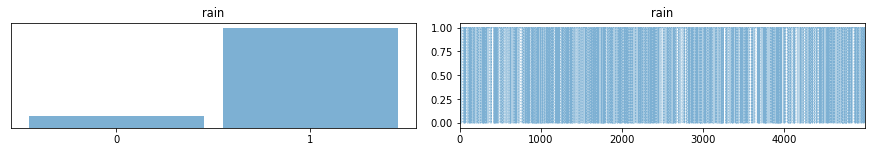

In [26]:
with pm.Model() as model: 
  # model the problem
  rain = pm.Bernoulli("rain", p=0.5) 
  p_yes = rain * 2/3 + (1-rain) * 1/3 
  likelihood = pm.Bernoulli("likelihood", p=p_yes, observed=[1,1,1]) 

  # solve it
  trace = pm.sample(5_000, chains=2, )
  samples = pm.sample_posterior_predictive(trace, var_names=["rain"], samples=10_000)
  
pm.traceplot(trace)

print("Posterior sampling of rain: ", samples['rain'].mean())

# Quantifying uncertainty

However, that solution seems incomplete to me. 
When we say we have a prior of p(rain) = 0.5, what is our confidence in that prior ? If we are absolutely certain, then new information should not influence us. If 0.5 was just a random guess, than we should only use new information. 

For that reason, I think it is more complete to state the problem using distributions to represent our belief. 

In order to do that, I will replace the `0.5` value in the rain prior by another distribution. This distribution, that I call `p_rain`, will represent my belief in the different potential values of `p` in the Bernouilli distribution. 

I can now use a Uniform distribution to represent that I don't know anything. I can use a more informative prior to represent some knowledge. I can even use the output of another Bayesian model as the input for this one !

If I use the Uniform prior, we can see that it is similar to using the `p=0.5` from aboe in the Bernouilli distribution, and leads to an expected value of 0.889 for the rain event. 

But what is very nice now, is that we have a visualisiation of our belief! In the `p_rain` graph that you see below, you can check for every value of the probability of rain what our belief is. 

<ipython-input-28-93cc484e2b94>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5_000, chains=2)
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [p_rain]
>BinaryGibbsMetropolis: [rain]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 14 seconds.


<ipython-input-28-93cc484e2b94>:13: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
/Users/rodolphe_cambier/miniconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Posterior sampling of rain:  0.8882


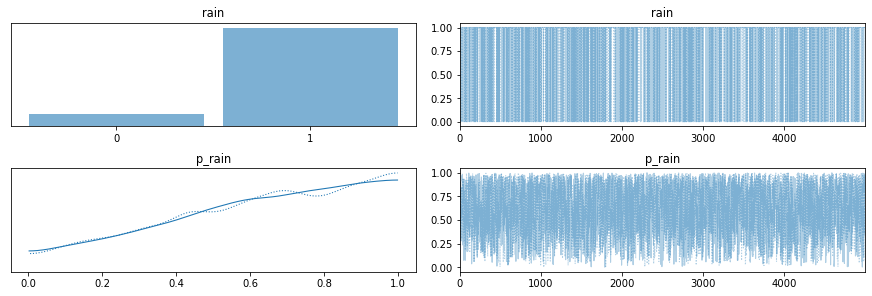

In [28]:
import pymc3 as pm
with pm.Model() as model: 
    # model the problem
    p_rain = pm.Uniform("p_rain", 0, 1) # this will now represent our belief
    rain = pm.Bernoulli("rain", p=p_rain) # we plug it in here
    p_yes = rain * 2/3 + (1-rain) * 1/3
    likelihood = pm.Bernoulli("likelihood", p=p_yes, observed=[1,1,1])

    # solve it
    trace = pm.sample(5_000, chains=2)
    samples = pm.sample_posterior_predictive(trace, var_names=["rain"], samples=10_000)

pm.traceplot(trace)

print("Posterior sampling of rain: ", samples['rain'].mean())

# Using an informative prior

We can also use a prior where we include some a-priori knowledge. 
For example, if we know that it rained 150 days last year, we could use a beta distribution with alpha=150 and beta=215 to represent that knowledge. (I don't explain here why such a distribution would encode that knowledge. It could for example be the posterior of a previous modelling effort.)

The chances of rain are now 0.8445. This is less than before. 
Notice also how our `p_rain` distribution represents a different belief. Way more centered around 0.41. 

<ipython-input-21-7289630af5f7>:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5_000, chains=2)
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [p_rain]
>BinaryGibbsMetropolis: [rain]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 11 seconds.


Posterior sampling of rain:  0.849


<ipython-input-21-7289630af5f7>:9: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
/Users/rodolphe_cambier/miniconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'rain'}>,
        <AxesSubplot:title={'center':'rain'}>],
       [<AxesSubplot:title={'center':'p_rain'}>,
        <AxesSubplot:title={'center':'p_rain'}>]], dtype=object)

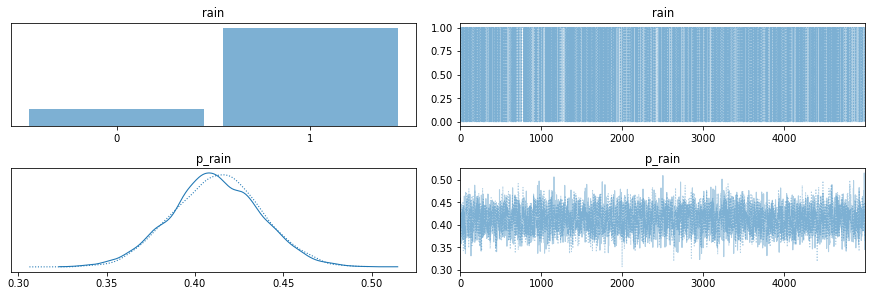

In [21]:
with pm.Model() as model: 
  # model the problem
  p_rain = pm.Beta("p_rain", 150, 215) # This encodes our beliefs of how much it rains in Seattle
  rain = pm.Bernoulli("rain", p=p_rain) 
  p_yes = rain * 2/3 + (1-rain) * 1/3 
  likelihood = pm.Bernoulli("likelihood", p=p_yes, observed=[1,1,1]) 

  # solve it
  trace = pm.sample(5_000, chains=2)
  samples = pm.sample_posterior_predictive(trace, var_names=["rain"], samples=10_000)
  print("Posterior sampling of rain: ", samples['rain'].mean())
pm.traceplot(trace)